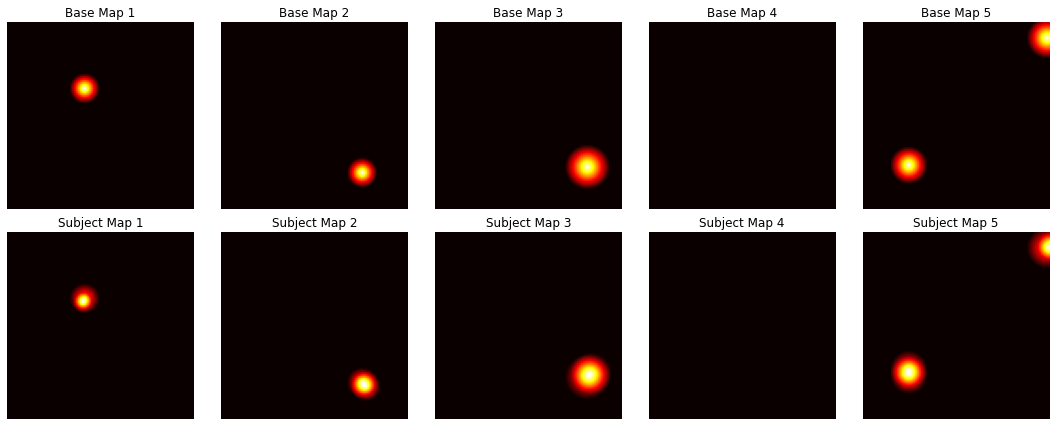

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

map_size = (100, 100) 
num_maps = 5           
blob_trials = 3     
blob_prob = 0.5        
gaussian_jitter_std = 2  

def generate_blob_map(map_size, num_blobs):
    """Generates a single map with the given number of blobs."""
    map_data = np.zeros(map_size)
    blobs = []
    
    for _ in range(num_blobs):
        # Randomly choose blob center and size
        center_x = np.random.randint(0, map_size[1])
        center_y = np.random.randint(0, map_size[0])
        radius = np.random.randint(5, 15)  # Random radius for blob
        
        # Avoid overlapping blobs
        for blob in blobs:
            dist = np.sqrt((center_x - blob[0])**2 + (center_y - blob[1])**2)
            if dist < radius + blob[2]:
                break
        else:
            blobs.append((center_x, center_y, radius))
            # Create a cone-shaped pattern
            for x in range(map_size[1]):
                for y in range(map_size[0]):
                    dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
                    if dist < radius:
                        map_data[y, x] += max(0, (1 - dist / radius))
    return map_data, blobs

def generate_latent_maps(num_maps, map_size, blob_trials, blob_prob, gaussian_jitter_std):
    """Generates multiple latent maps with blobs and subject-specific jitter."""
    maps = []
    all_blobs = []
    
    for _ in range(num_maps):
        # Number of blobs from binomial distribution
        num_blobs = binom.rvs(blob_trials, blob_prob)
        
        # Generate the base map
        base_map, blobs = generate_blob_map(map_size, num_blobs)
        maps.append(base_map)
        all_blobs.append(blobs)
    
    # Add Gaussian jitter to create subject-specific maps
    subject_maps = []
    for base_map, blobs in zip(maps, all_blobs):
        subject_map = np.copy(base_map)
        for blob in blobs:
            center_x, center_y, radius = blob
            
            # Apply Gaussian jitter
            jitter_x = int(np.random.normal(center_x, gaussian_jitter_std))
            jitter_y = int(np.random.normal(center_y, gaussian_jitter_std))
            jitter_radius = max(1, int(np.random.normal(radius, gaussian_jitter_std)))
            
            # Add jittered blob to the map
            for x in range(map_size[1]):
                for y in range(map_size[0]):
                    dist = np.sqrt((x - jitter_x)**2 + (y - jitter_y)**2)
                    if dist < jitter_radius:
                        subject_map[y, x] += max(0, (1 - dist / jitter_radius))
        
        subject_maps.append(subject_map)
    
    return maps, subject_maps

# Generate maps
base_maps, subject_maps = generate_latent_maps(num_maps, map_size, blob_trials, blob_prob, gaussian_jitter_std)

# Visualize maps
fig, axes = plt.subplots(2, num_maps, figsize=(15, 6))
for i, (base_map, subject_map) in enumerate(zip(base_maps, subject_maps)):
    axes[0, i].imshow(base_map, cmap='hot')
    axes[0, i].set_title(f"Base Map {i+1}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(subject_map, cmap='hot')
    axes[1, i].set_title(f"Subject Map {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


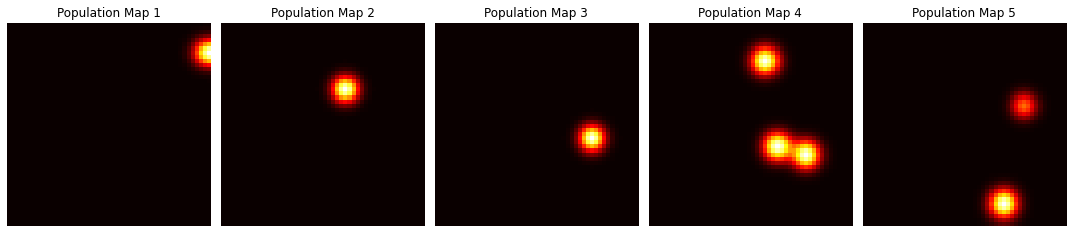

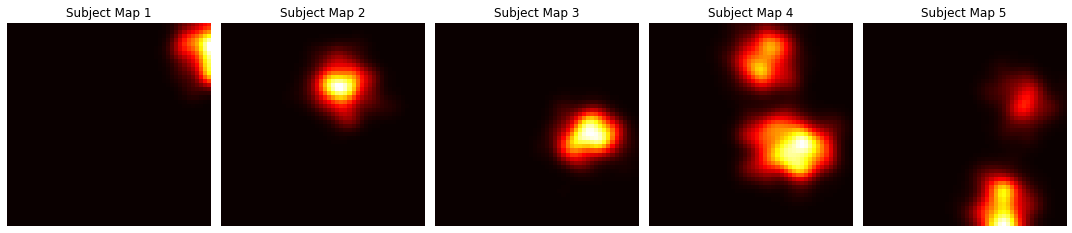

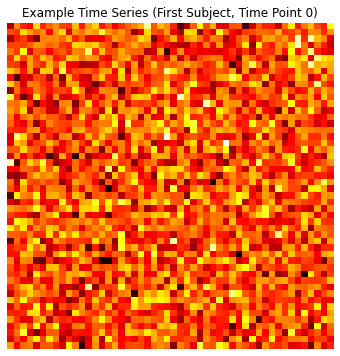

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Parameters
num_subjects = 12       # Number of subjects
num_maps = 5            # Number of latent spatial maps
time_points = 150       # Number of time points
grid_size = (50, 50)    # Spatial grid size
smoothness = 2          # Smoothness in pixels (Gaussian filter sigma)
jitter_std = 3          # Jitter standard deviation in pixels
blob_trials = 3         # Binomial trials for blob count
blob_prob = 0.5         # Probability for blob success
blob_radius_range = (2, 5)  # Range of blob radii

def generate_base_maps(num_maps, grid_size, blob_trials, blob_prob, blob_radius_range):
    """Generates shared population maps with smooth blobs."""
    base_maps = []
    for _ in range(num_maps):
        map_data = np.zeros(grid_size)
        num_blobs = np.random.binomial(blob_trials, blob_prob)
        for _ in range(num_blobs):
            center_x = np.random.randint(0, grid_size[1])
            center_y = np.random.randint(0, grid_size[0])
            radius = np.random.randint(*blob_radius_range)
            for x in range(grid_size[1]):
                for y in range(grid_size[0]):
                    dist = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
                    if dist < radius:
                        map_data[y, x] += max(0, (1 - dist / radius))
        # Smooth the map using Gaussian filter
        base_maps.append(gaussian_filter(map_data, sigma=smoothness))
    return base_maps

def generate_subject_maps(base_maps, grid_size, jitter_std):
    """Adds subject-specific jitter to base maps."""
    subject_maps = []
    for base_map in base_maps:
        subject_map = np.zeros(grid_size)
        non_zero_coords = np.argwhere(base_map > 0)
        for coord in non_zero_coords:
            y, x = coord
            jittered_x = int(np.clip(np.random.normal(x, jitter_std), 0, grid_size[1] - 1))
            jittered_y = int(np.clip(np.random.normal(y, jitter_std), 0, grid_size[0] - 1))
            subject_map[jittered_y, jittered_x] += base_map[y, x]
        # Smooth the jittered map
        subject_maps.append(gaussian_filter(subject_map, sigma=smoothness))
    return subject_maps

def generate_time_series(subject_maps, time_points):
    """Generates a synthetic time series for each subject."""
    time_series = []
    for subject_map in subject_maps:
        series = np.zeros((time_points,) + subject_map.shape)
        for t in range(time_points):
            series[t] = subject_map + np.random.normal(0, 0.1, subject_map.shape)  # Add noise
        time_series.append(series)
    return np.array(time_series)

# Generate population maps
population_maps = generate_base_maps(num_maps, grid_size, blob_trials, blob_prob, blob_radius_range)

# Generate subject-specific maps for all subjects
subject_data = []
for _ in range(num_subjects):
    subject_data.append(generate_subject_maps(population_maps, grid_size, jitter_std))

# Generate time series
synthetic_time_series = [generate_time_series(subject_maps, time_points) for subject_maps in subject_data]

# Visualize population maps
fig, axes = plt.subplots(1, num_maps, figsize=(15, 5))
for i, pop_map in enumerate(population_maps):
    axes[i].imshow(pop_map, cmap='hot', interpolation='nearest')
    axes[i].set_title(f"Population Map {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Visualize subject maps for the first subject
fig, axes = plt.subplots(1, num_maps, figsize=(15, 5))
for i, subj_map in enumerate(subject_data[0]):
    axes[i].imshow(subj_map, cmap='hot', interpolation='nearest')
    axes[i].set_title(f"Subject Map {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Display an example time series slice
example_time_series = synthetic_time_series[0]  # First subject
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(example_time_series[0][0], cmap='hot', interpolation='nearest')  # Time point 0
ax.set_title("Example Time Series (First Subject, Time Point 0)")
ax.axis('off')
plt.show()
